# EDA

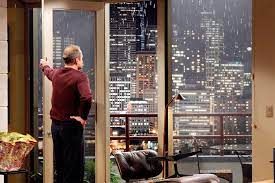

In [155]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.2f' % x)


pd.set_option('display.max_columns', 50)

# Stakeholder
Timothy Stevens: Owns expensive houses in the center, needs to get rid, best timing within a year, open for renovation when profits rise.

# Import the data

In [156]:
df = pd.read_csv("data/King_County_House_prices_dataset.csv")

# Understanding the data


In [157]:
df.info()
# waterfront and yr_renovated contain NAs
# date needs to be converted
# Better description of columns can be found here: https://geodacenter.github.io/data-and-lab/KingCounty-HouseSales2015/
# Info on Zipcodes: https://gis-kingcounty.opendata.arcgis.com/datasets/zipcodes-for-king-county-and-surrounding-area-shorelines-zipcode-shore-area/explore?location=47.504243%2C-121.477600%2C8.67
# sqft_living15 is the avarage size of living space of the closest 15 neighbours. Will help to determine if a house is bigger compared to neighbors.
# view - An index from 0 to 4 of how good the view of the property was
#condition - An index from 1 to 5 on the condition of the apartment,
#grade - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

# Research questions + hypotheses and Todo
Stakeholder: Timothy Stevens: Owns expensive houses in the center, needs to get rid, best timing within a year, open for renovation when profits rise.

Question: When is the best timing to sell houses?
Hypothesis: The avarage price varies over the year

Question: Will a recent renovation increase the selling price?
Hypothesis: Houses renovated in the same year have a higher avarage price.

Hypothesis: There is a correlation between grade and price, sqft_living and price.
Hypothesis: View, grade and condition are positively correlated.


Geohypo: Plot a map with $/sqft per zipcode. Hypo: Higher in seattle.


For the EDA:
1. Filter for houses in the center (by zipcode?). What is the center? Seattle?
2. Define 'expensive' (80% quartile?). 




# Data exploration

In [158]:
#df.hist(column=["price","bedrooms","sqft_living","floors","grade","yr_built","yr_renovated","sqft_living15"],layout=(4,2),figsize=(12,6))

# There are a few very big very very expensive houses
# Filter them for a first glance

#df[df.price < 4000000].hist(column=["price","bedrooms","sqft_living","floors","grade","yr_built","yr_renovated","sqft_living15"],layout=(4,2),figsize=(12,6))

# There seem to be some houses that are very high cost and/or high number of bedrooms, very high number of sqft_living. Maybe outliers? need to check.
# Most houses have not been renovated which is sometimes a 0 and sometimes NaN !

df[df.price > 7000000]
# 45 houses over 3 million
# 2 houses over 7 million

df[df.bedrooms > 10]
# 2 houses with more than 10 bedrooms, 33 bedrooms one is probably a typo because it is not too big.

df[df.sqft_living > 8000]
# 211 houses with over 5k sqft living
# 9 houses with over 8k sqft living. all with high grade and a high price so probably valid data.




# Note: Delete the 33 bedroom one, apart from that all looks 'normal'



,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1162,1247600105,10/20/2014,5110000.00,5,5.25,8010,45517,2.00,1.00,4.00,3,12,5990,2020.0,1999,0.00,98033,47.68,-122.21,3430,26788
3910,9808700762,6/11/2014,7060000.00,5,4.50,10040,37325,2.00,1.00,2.00,3,11,7680,2360.0,1940,2001.00,98004,47.65,-122.21,3930,25449
4407,2470100110,8/4/2014,5570000.00,5,5.75,9200,35069,2.00,0.00,0.00,3,13,6200,3000.0,2001,NaN,98039,47.63,-122.23,3560,24345
7245,6762700020,10/13/2014,7700000.00,6,8.00,12050,27600,2.50,0.00,3.00,4,13,8570,3480.0,1910,1987.00,98102,47.63,-122.32,3940,8800
8085,1924059029,6/17/2014,4670000.00,5,6.75,9640,13068,1.00,1.00,4.00,3,12,4820,4820.0,1983,2009.00,98040,47.56,-122.21,3270,10454
9245,9208900037,9/19/2014,6890000.00,6,7.75,9890,31374,2.00,0.00,4.00,3,13,8860,1030.0,2001,0.00,98039,47.63,-122.24,4540,42730
12764,1225069038,5/5/2014,2280000.00,7,8.00,13540,307752,3.00,0.00,4.00,3,12,9410,4130.0,1999,0.00,98053,47.67,-121.99,4850,217800
14542,2303900035,6/11/2014,2890000.00,5,6.25,8670,64033,2.00,0.00,4.00,3,13,6120,2550.0,1965,NaN,98177,47.73,-122.37,4140,81021
18288,6072800246,7/2/2014,3300000.00,5,6.25,8020,21738,2.00,0.00,0.00,3,11,8020,0.0,2001,NaN,98006,47.57,-122.19,4160,18969


# Feature engineering

In [159]:
# Seattle column. 

# Zip codes for seattle
#sorted(df.zipcode.unique())

# Seattle Zipcodes range from 98101-98199 (only 64 are taken)(https://www.zipcode.com.ng/2022/12/seattle-zip-codes-wa.html)

df["seattle"] = df.zipcode.between(98101,98200)
df.groupby("seattle").mean()

# Interestingly the avarage price does not differ, but houses within Seattle are smaller, with fewer bed and bathrooms and the lot is much smaller.




,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
seattle,,,,,,,,,,,,,,,,,,,
False,4564301555.56,544000.48,3.52,2.27,2282.88,21243.16,1.52,0.01,0.19,3.39,7.88,2034.13,1982.40,53.77,98038.37,47.52,-122.13,2202.57,17432.36
True,4603227499.79,535085.60,3.17,1.89,1795.34,6455.84,1.46,0.01,0.30,3.44,7.34,1443.16,1954.96,126.14,98133.64,47.61,-122.33,1682.80,6182.39


In [160]:
# Price per sqft


df["price_sqft_liv"] = df.price / df.sqft_living
df["price_sqft_lot"] = df.price / df.sqft_lot
df.groupby("seattle").mean()

# Price per sqft is higher in seattle compared to the outskirts. However, the difference is even higher for the lot price.


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_sqft_liv,price_sqft_lot
seattle,,,,,,,,,,,,,,,,,,,,,
False,4564301555.56,544000.48,3.52,2.27,2282.88,21243.16,1.52,0.01,0.19,3.39,7.88,2034.13,1982.40,53.77,98038.37,47.52,-122.13,2202.57,17432.36,235.25,59.64
True,4603227499.79,535085.60,3.17,1.89,1795.34,6455.84,1.46,0.01,0.30,3.44,7.34,1443.16,1954.96,126.14,98133.64,47.61,-122.33,1682.80,6182.39,304.79,130.28


In [161]:
# Center = Seattle might not be the best definition.
# Alternatively, I will use the Top10 Zipcodes with the highest population density according to: http://www.usa.com/rank/king-county-wa--population-density--zip-code-rank.htm?yr=9000&dis=&wist=&plow=&phigh=

df["center"] = df.zipcode.isin([98164,98174,98121,98101,98104,98102,98122,98109,98107,98103])

df.groupby(["seattle","center"]).mean()
# Very cool. Price per sqft rises from rural -> seattle -> center

id     price  bedrooms  bathrooms  sqft_living  \
seattle center                                                             
False   False  4564301555.56 544000.48      3.52       2.27      2282.88   
True    False  4597128036.08 515860.43      3.18       1.87      1806.15   
        True   4637048158.47 641686.44      3.09       2.03      1735.45   

                sqft_lot  floors  waterfront  view  condition  grade  \
seattle center                                                         
False   False   21243.16    1.52        0.01  0.19       3.39   7.88   
True    False    6997.50    1.40        0.01  0.32       3.44   7.29   
        True     3452.42    1.82        0.00  0.20       3.43   7.60   

                sqft_above  yr_built  yr_renovated  zipcode   lat    long  \
seattle center                                                              
False   False      2034.13   1982.40         53.77 98038.37 47.52 -122.13   
True    False      1441.68   1955.33        123.83 98138.23 47.61 -122.33   
        True       1451.36   1952.88        139.18 98108.20 47.65 -122.34   

                sqft_living15  sqft_lot15  price_sqft_liv  price_sqft_lot  
seattle center                                                             
False   False         2202.57    17432.36          235.25           59.64  
True    False         1692.75     6669.29          291.03          110.43  
        True          1627.64     3482.60          381.09          240.34

# Data Cleaning

datetime64[ns]


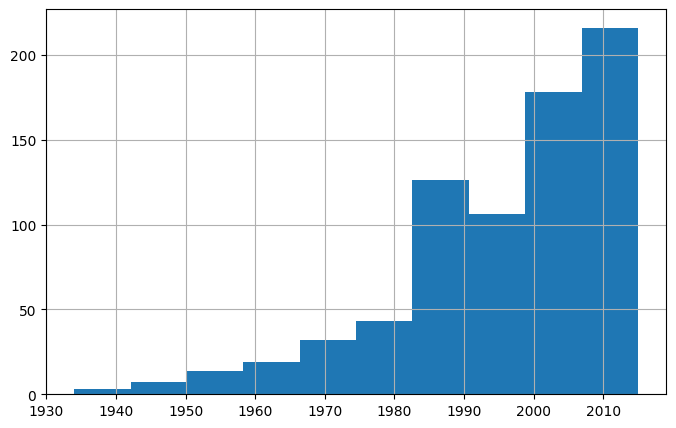

In [162]:
# Drop the 33 bedroom row.
df = df[df.bedrooms < 33]

# get the date right
df["date"] = pd.to_datetime(df.date, format= '%m/%d/%Y')

# year renovated has some strange data according to the histograms
df.yr_renovated 
# Seems that non-renovated houses either have a NaN or a 0. Convert 0 to NaN
df["yr_renovated"] = df["yr_renovated"].replace(0,np.nan)
df["yr_renovated"].hist() # Looking better now.

print(df.date.dtypes)


# Correlations


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,yr_built,yr_renovated,sqft_living15,sqft_lot15,price_sqft_liv,price_sqft_lot,center
price,1.00,0.32,0.53,0.70,0.09,0.26,0.40,0.04,0.67,0.61,0.05,0.13,0.59,0.08,0.56,0.31,0.07
bedrooms,0.32,1.00,0.53,0.59,0.03,0.18,0.08,0.02,0.37,0.49,0.16,0.16,0.40,0.03,-0.21,-0.06,-0.09
bathrooms,0.53,0.53,1.00,0.76,0.09,0.50,0.19,-0.13,0.67,0.69,0.51,0.25,0.57,0.09,-0.09,0.20,-0.03
sqft_living,0.70,0.59,0.76,1.00,0.17,0.35,0.28,-0.06,0.76,0.88,0.32,0.13,0.76,0.18,-0.09,0.02,-0.10
sqft_lot,0.09,0.03,0.09,0.17,1.00,-0.00,0.08,-0.01,0.11,0.18,0.05,-0.08,0.14,0.72,-0.03,-0.21,-0.07
floors,0.26,0.18,0.50,0.35,-0.00,1.00,0.03,-0.26,0.46,0.52,0.49,0.06,0.28,-0.01,0.00,0.48,0.16
view,0.40,0.08,0.19,0.28,0.08,0.03,1.00,0.05,0.25,0.17,-0.05,-0.06,0.28,0.07,0.22,0.08,-0.01
condition,0.04,0.02,-0.13,-0.06,-0.01,-0.26,0.05,1.00,-0.15,-0.16,-0.36,-0.36,-0.09,-0.00,0.10,-0.09,0.01
grade,0.67,0.37,0.67,0.76,0.11,0.46,0.25,-0.15,1.00,0.76,0.45,0.24,0.71,0.12,0.13,0.22,-0.01
sqft_above,0.61,0.49,0.69,0.88,0.18,0.52,0.17,-0.16,0.76,1.00,0.42,0.05,0.73,0.20,-0.09,-0.00,-0.11


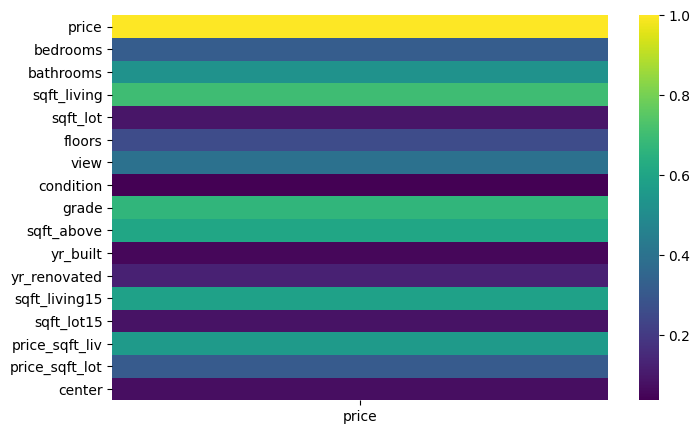

In [163]:
# 1. condition, view and grade
df[["grade","view","condition","seattle"]].groupby("seattle").corr()
# Grade and view are marginally correlated, but condition isn't. Might be worth to deepdive in what exactly they mean.
# View = quality der Besichtigung???
# Grade = How well is it constructed?
# Condition = Wie gut ist es in Schuss?!

# What influences the price?
df[["grade","view","condition","seattle"]].groupby("seattle").corr()
corr_mat_price = df.drop(["id","date","waterfront","zipcode","lat","long","seattle"],axis=1).corr()
sns.heatmap(corr_mat_price[["price"]], cmap="viridis")
corr_mat_price[["price"]]
# Factors influencing the price (> 50%)
# Bathrooms, sqft-living, grade, sqft_above, sqft_living15
# However, yr_renovated doesnt make sense without changing it!!!


### Note: Scatter
corr_mat_price

# Answering research questions
# 1. How does selling price fluctuate over the year

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,seattle,price_sqft_liv,price_sqft_lot,center,week
high_price,,,,,,,,,,,,,,,,,,,,,,,,
False,4557654242.49,528691.97,3.36,2.11,2072.51,15035.61,1.49,0.01,0.23,3.41,7.64,1785.39,1971.07,1995.76,98077.57,47.56,-122.21,1978.24,12581.43,0.41,259.10,86.85,0.06,25.60
True,4611044128.69,556113.66,3.38,2.12,2090.99,15190.67,1.50,0.01,0.24,3.41,7.68,1793.11,1970.92,1996.15,98078.47,47.56,-122.21,1998.28,13003.51,0.42,271.03,91.90,0.06,27.06


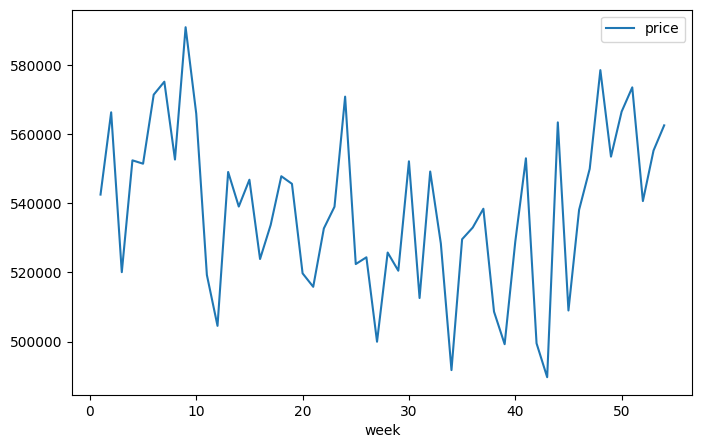

In [164]:
df.date.value_counts() # there are days with only 1 sale per day so might not be a good idea to aggregate per day.
df.date.dt.week.value_counts() # looks better

# However there is some overlap in May. So lets make a better week column.
df.date.describe()
df["week"] = (df["date"] - pd.to_datetime("2014-05-02")).dt.days // 7 + 1

df.week.value_counts() # Almost no data in the last two weeks. Get rid of it, since we have data on the timespan of 1 year.

df_weekly = df[df.week < 55]

df_weekly.groupby("week").mean("price").reset_index().plot.line(x="week",y="price")
# A lot of week to week variation and generally speaking the avg sales price varies by up to 15% depending on time.
# It seems like Sales prices in week 1-10 and 45 - 54 are a bit higher which would be Mid March - Beginning of July 

# Lets check data on that assumption:
df_weekly["high_price"] = df_weekly.week.isin(list(range(1,11))+list(range(45,55)))
df_weekly.groupby("high_price").mean("price")
# The avarage selling price in the above mentioned time span is 27.5k higher. However, the high week2week variation needs to be considered.








# Follow up.
# Does this hold true for the center as well????




# 2. Does a recent renovation increase the selling price?

In [181]:
# Things to consider: Drop recently built houses since they will have a high selling price and no renovation yet.
# Lets randomly go up to yr_built 2000 and define recently as "within the last 5 years". DOESNT REALLY INFLUENCE IT.
df_reno = df

sorted(df_reno.yr_renovated.unique()) #even some renovated in 2015
df_reno.yr_renovated.value_counts() # Wow, most were renovated in 2014

df_reno["recent_reno"] = df_reno.yr_renovated.isin([2010,2011,2012,2013,2014,2015])
sum(df_reno["recent_reno"]) # 150

# The number is relatively low but let's see what it does:
df_reno.groupby("recent_reno").mean() # The price is higher even after correcting for the difference in sqft_living (see price per sqft).
# There seems to be a high demand for newly renovated houses.

# Lets compare it with houses that were never renovated
# But be careful we don't know if initial NaN values mean no renovation of if its reno_date is unknown.

df_reno["renovated"] = ~df_reno.yr_renovated.isna() # The ~ reverts True and False apparently.
df_reno.groupby("renovated").mean()
# A renovation no matter if recent or not increases the avarage sale price.

df_reno.groupby(["renovated","recent_reno"]).mean()
# The main difference (price / sqft) is between no renovated and renovated. a recent_renovation only rises the price every to slightly.
# Timothy should therefore only renovate those houses that have never been renovated.





# Further question:
# Is there a yr_renovated threshold were the price of renovated == unrenovated

# Do the groupby in pivot_table

# Careful because of lower n. 744 renovated.


744

In [173]:
df[df.yr_built < 2000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,seattle,price_sqft_liv,price_sqft_lot,center,week,recent_reno,renovated
0,7129300520,2014-10-13,221900.00,3,1.00,1180,5650,1.00,NaN,0.00,3,7,1180,0.0,1955,NaN,98178,47.51,-122.26,1340,5650,True,188.05,39.27,False,24,False,False
1,6414100192,2014-12-09,538000.00,3,2.25,2570,7242,2.00,0.00,0.00,3,7,2170,400.0,1951,1991.00,98125,47.72,-122.32,1690,7639,True,209.34,74.29,False,32,False,True
2,5631500400,2015-02-25,180000.00,2,1.00,770,10000,1.00,0.00,0.00,3,6,770,0.0,1933,NaN,98028,47.74,-122.23,2720,8062,False,233.77,18.00,False,43,False,False
3,2487200875,2014-12-09,604000.00,4,3.00,1960,5000,1.00,0.00,0.00,5,7,1050,910.0,1965,NaN,98136,47.52,-122.39,1360,5000,True,308.16,120.80,False,32,False,False
4,1954400510,2015-02-18,510000.00,3,2.00,1680,8080,1.00,0.00,0.00,3,8,1680,0.0,1987,NaN,98074,47.62,-122.05,1800,7503,False,303.57,63.12,False,42,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21287,522059130,2015-04-29,465000.00,3,1.00,1150,18200,1.00,0.00,0.00,5,7,1150,0.0,1959,NaN,98058,47.43,-122.19,1714,18200,False,404.35,25.55,False,52,False,False
21316,9266700190,2015-05-11,245000.00,1,1.00,390,2000,1.00,0.00,0.00,4,6,390,0.0,1920,NaN,98103,47.69,-122.35,1340,5100,True,628.21,122.50,True,54,False,False
21327,2924079034,2014-09-25,332220.00,3,1.50,2580,47480,1.00,0.00,0.00,3,7,1360,1220.0,1953,NaN,98024,47.53,-121.93,1760,48181,False,128.77,7.00,False,21,False,False
21454,121039156,2015-01-09,249000.00,3,1.00,1030,24750,1.00,0.00,2.00,3,5,1030,0.0,1943,NaN,98023,47.33,-122.36,2810,28800,False,241.75,10.06,False,37,False,False
